In [1]:
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import spearmanr
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from preprocessing import *
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("data/CTU-13-Dataset/10/capture20110818.binetflow")

In [3]:
df.columns

Index(['StartTime', 'Dur', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr',
       'Dport', 'State', 'sTos', 'dTos', 'TotPkts', 'TotBytes', 'SrcBytes',
       'Label'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309791 entries, 0 to 1309790
Data columns (total 15 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   StartTime  1309791 non-null  object 
 1   Dur        1309791 non-null  float64
 2   Proto      1309791 non-null  object 
 3   SrcAddr    1309791 non-null  object 
 4   Sport      1302804 non-null  object 
 5   Dir        1309791 non-null  object 
 6   DstAddr    1309791 non-null  object 
 7   Dport      1205576 non-null  object 
 8   State      1308563 non-null  object 
 9   sTos       1296939 non-null  float64
 10  dTos       1123000 non-null  float64
 11  TotPkts    1309791 non-null  int64  
 12  TotBytes   1309791 non-null  int64  
 13  SrcBytes   1309791 non-null  int64  
 14  Label      1309791 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 149.9+ MB


In [5]:
df.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


## Encode Labels and Drop Background Flows

- normal = 0
- botnet = 1
- background = 2

In [6]:
df_encoded = encode_labels(df)

The counts of the flows match what is given on the website

In [7]:
df_encoded["Label"].value_counts()

2    1187592
1     106352
0      15847
Name: Label, dtype: int64

In [8]:
df.isna().sum()

StartTime         0
Dur               0
Proto             0
SrcAddr           0
Sport          6987
Dir               0
DstAddr           0
Dport        104215
State          1228
sTos          12852
dTos         186791
TotPkts           0
TotBytes          0
SrcBytes          0
Label             0
dtype: int64

### Encode features

In [9]:
df_encoded.loc[df_encoded["Sport"].isna(), "Sport"] = "UNK"
sport_enc = LabelEncoder()
df_encoded.loc[:, "Sport"] = sport_enc.fit_transform(df_encoded["Sport"])

df_encoded.loc[df_encoded["Dport"].isna(), "Dport"] = "UNK"
dport_enc = LabelEncoder()
df_encoded.loc[:, "Dport"] = dport_enc.fit_transform(df_encoded["Dport"])

df_encoded.loc[df_encoded["State"].isna(), "State"] = "UNK"
state_enc = LabelEncoder()
df_encoded.loc[:, "State"] = state_enc.fit_transform(df_encoded["State"])

df_encoded.loc[df_encoded["sTos"].isna(), "sTos"] = -999
stos_enc = LabelEncoder()
df_encoded.loc[:, "sTos"] = stos_enc.fit_transform(df_encoded["sTos"])

df_encoded.loc[df_encoded["dTos"].isna(), "dTos"] = -999
dtos_enc = LabelEncoder()
df_encoded.loc[:, "dTos"] = dtos_enc.fit_transform(df_encoded["dTos"])

proto_enc = LabelEncoder()
df_encoded.loc[:, "Proto"] = proto_enc.fit_transform(df_encoded["Proto"])

dir_enc = LabelEncoder()
df_encoded.loc[:, "Dir"] = dir_enc.fit_transform(df_encoded["Dir"])

srcaddr_enc = LabelEncoder()
df_encoded.loc[:, "SrcAddr"] = srcaddr_enc.fit_transform(df_encoded["SrcAddr"])

dstaddr_enc = LabelEncoder()
df_encoded.loc[:, "DstAddr"] = dstaddr_enc.fit_transform(df_encoded["DstAddr"])

In [10]:
df_filtered = drop_background_flows(df_encoded)

In [11]:
df_filtered["Label"].value_counts()

1    106352
0     15847
Name: Label, dtype: int64

## Find correlations between features and label

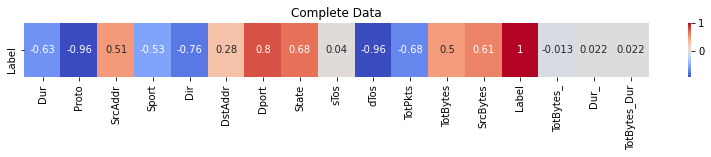

In [63]:
#correlation matrices
f, (ax1) = plt.subplots(1,figsize =(14, 1))
sns.heatmap(df_filtered.corr("spearman").loc[['Label']],cmap = 'coolwarm', annot=True)
ax1.set_title('Complete Data')
plt.show()


# f, (ax1, ax2) = plt.subplots(1,2,figsize =(16, 8))

# sns.heatmap(df_filtered[df_filtered["Label"] == 1].corr("spearman"), vmax = .8, square=True, ax = ax1, cmap = 'YlGnBu')
# ax1.set_title('Malicious')

# sns.heatmap(df_filtered[df_filtered["Label"] == 0].corr("spearman"), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu');
# ax2.set_title('Normal')

# plt.show()

In [13]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.501
Samples are correlated (reject H0) p=0.000


In [14]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: -0.627
Samples are correlated (reject H0) p=0.000


## 3. Find the optimal number of bins for discretization

- Use kmeans for discretization
- Use the elbow method by plotting the within cluster sum of squares vs number of clusters
- Use cluster labels as the discretized values
- Sort the clusters according to the ordinal rank of the feature

In [15]:
def visualize_discretization(feature, min_k=2, max_k=15):
    distortions = {}
    kmeans_models = {}
    for k in tqdm(range(min_k, max_k)):
        kmeans_model = KMeans(n_clusters=k)
        kmeans_model.fit(feature)
        kmeans_models[k] = kmeans_model
        distortions[k] = kmeans_model.inertia_

    plt.figure(figsize=(16,8))
    plt.plot(range(min_k, max_k), list(distortions.values()), 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    
    return kmeans_models, distortions

In [16]:
df_filtered["sTos"].value_counts()

1    122170
0        29
Name: sTos, dtype: int64

## Numerically Encode Dir and Proto features

### 1.1 Discretization of TotBytes

In [17]:
df_filtered, dir_enc = encode(df_filtered, "Dir")
df_filtered, protocol_enc = encode(df_filtered, "Proto")

100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


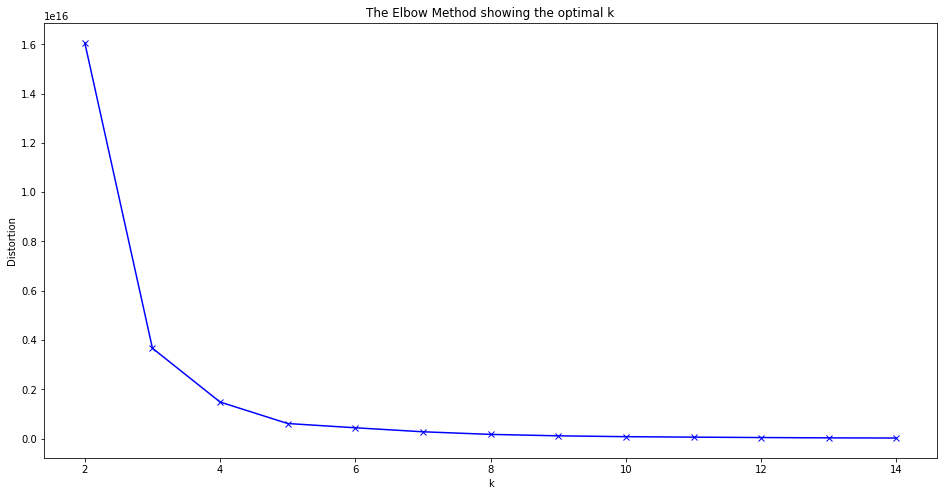

In [18]:
tot_bytes = df_filtered["TotBytes"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(tot_bytes)

Choosing k = 5

In [19]:
# discretize
df_filtered.loc[:, "TotBytes_"] = kmeans_models[4].predict(tot_bytes)

In [20]:
df_filtered.TotBytes_.value_counts()

0    122006
2       158
3        25
1        10
Name: TotBytes_, dtype: int64

### 1.2 Discretization of TotBytes

100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


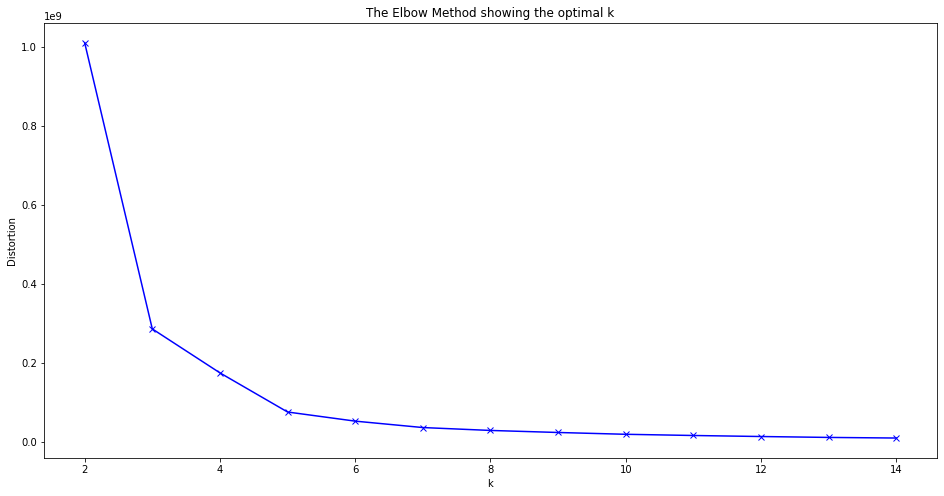

In [21]:
dur = df_filtered["Dur"].to_numpy().reshape(-1, 1)
kmeans_models, distortions = visualize_discretization(dur)

Choosing k = 5

In [22]:
# discretize
df_filtered.loc[:, "Dur_"] = kmeans_models[5].predict(dur)

In [23]:
df_filtered.Dur_.value_counts()

0    111308
3      7279
1      2173
4      1307
2       132
Name: Dur_, dtype: int64

### 1.3 Sort the clusters according to the ordinal rank of the features

In [24]:
# ## order the total bytes discretized values according to its ordinal rank
# min_list = []
# for i in range(5):
#     min_list.append((i, df_filtered[df_filtered["TotBytes_"] == i]["TotBytes"].describe()["min"]))
# min_list = sorted(min_list, key=lambda x: x[1])

# cluster_indices = []
# for i in range(5):
#     cluster_indices.append(df_filtered["TotBytes_"] == i)

# cluster_ordinal_map = {i: c[0] for i, c in enumerate(min_list)}

# for i, c in enumerate(min_list):
#     df_filtered.loc[cluster_indices[i], "TotBytes_"] = c[0]

In [25]:
# ## order the duration discretized values according to its ordinal rank
# min_list = []
# for i in range(5):
#     min_list.append((i, df_filtered[df_filtered["Dur_"] == i]["Dur"].describe()["min"]))
# min_list = sorted(min_list, key=lambda x: x[1], reverse=True)

# cluster_indices = []
# for i in range(5):
#     cluster_indices.append(df_filtered["Dur_"] == i)

# cluster_ordinal_map = {i: c[0] for i, c in enumerate(min_list)}

# for i, c in enumerate(min_list):
#     df_filtered.loc[cluster_indices[i], "Dur_"] = c[0]

## 2. Encoding using Attributes Mapping algorithm

_Algorithm 1 from [G. Pellegrino et.al. Learning Behavioral Fingerprints From Netflows Using Timed Automata](http://dl.ifip.org/db/conf/im/im2017/036.pdf)_

We combine `TotBytes` and `Dur` using this algorithm

In [26]:
num_bins = {"TotBytes_": 4, "Dur_": 5}

In [27]:
def attribute_mapping_encode(row):
    code = 0
    features = row.index
    space_size = reduce((lambda x, y: num_bins[x] * num_bins[y]), features)
    for feature in features:
        code = code + row[feature]*space_size/num_bins[feature]
        space_size = space_size/num_bins[feature]
    return code

In [28]:
df_filtered["TotBytes_Dur"] = df_filtered[["TotBytes_", "Dur_"]].apply(attribute_mapping_encode, axis=1)

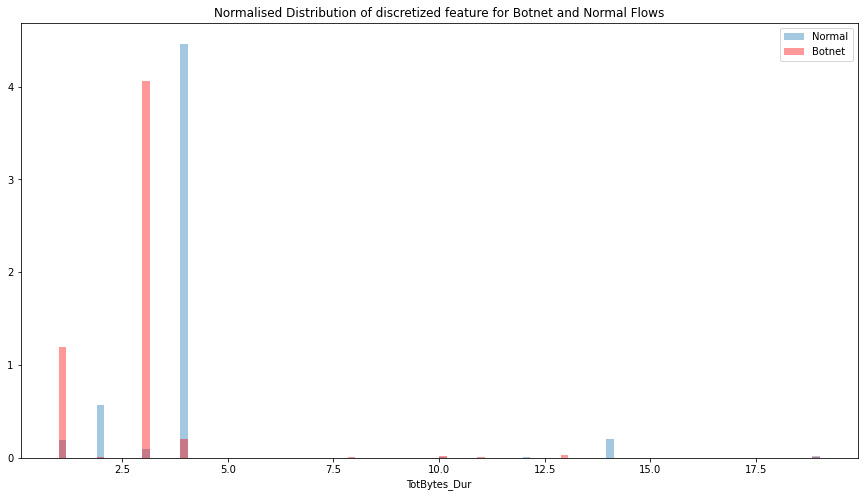

In [41]:
f, (ax1) = plt.subplots(1,1,figsize =(15, 8))

ax1.set_title("Normalised Distribution of discretized feature for Botnet and Normal Flows")
sns.distplot(df_filtered[(df_filtered["Label"] == 0)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax1, bins=100, label="Normal", norm_hist=True)
sns.distplot(df_filtered[(df_filtered["Label"] == 1)&(df_filtered["TotBytes_Dur"] > 0)]["TotBytes_Dur"], kde=False, ax=ax1, bins=100, label="Botnet", norm_hist=True, color='red')
ax1.legend()


In [30]:
coef, p = spearmanr(df_filtered["Label"], df_filtered["TotBytes_Dur"])
print('Spearmans correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Spearmans correlation coefficient: 0.022
Samples are correlated (reject H0) p=0.000
